In [1]:
import pandas as pd
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


smb.cmd = 0x72 (NEGOTIATE)
smb.dialect = NT LM 0.12
❌ Attack
✅ Normal

smb.cmd = 0xa0 (NT_TRANSACT)
smb.dialect = NT LM 0.12
✅ Attack


===== SMB Columns Found in normal file =====
['smb.cmd', 'smb.dialect']

===== UNIQUE VALUES =====

--- smb.cmd ---
['0x72' '0x25' '0x73' '0x75' '0x71' '0x74']

--- smb.dialect ---
['MICROSOFT NETWORKS 3.0' 'PC NETWORK PROGRAM 1.0']

===== SMB Columns Found  in attack file=====
['smb.cmd', 'smb.dialect']

===== UNIQUE VALUES =====

--- smb.cmd ---
['0x72' '0x73' '0x75' '0x25' '0x32' '0xa0' '0x33' '0x2b']

--- smb.dialect ---
['LANMAN1.0' 'NT LM 0.12']

In [2]:

normal_files = glob.glob("../data/processed/csv/normal/normaltraffic*.csv")
attack_files = glob.glob("../data/processed/csv/attack/attacktraffic*.csv")

In [3]:
import glob
import pandas as pd

normal_files = glob.glob("../data/processed/csv/normal/normaltraffic*.csv")
attack_files = glob.glob("../data/processed/csv/attack/attacktraffic*.csv")

df_normal = pd.read_csv(normal_files[0])
print(df_normal.columns)


df_attack = pd.read_csv(attack_files[0])
print(df_attack.columns)


Index(['frame.len', 'frame.time', 'ip.src', 'ip.dst', 'ip.ttl',
       'frame.protocols', 'tcp.srcport', 'tcp.dstport', 'tcp.flags',
       'udp.srcport', 'udp.dstport', 'smb.cmd', 'smb.dialect'],
      dtype='object')
Index(['frame.len', 'frame.time', 'ip.src', 'ip.dst', 'ip.ttl',
       'frame.protocols', 'tcp.srcport', 'tcp.dstport', 'tcp.flags',
       'udp.srcport', 'udp.dstport', 'smb.cmd', 'smb.dialect'],
      dtype='object')


In [4]:
def get_unique_values(files, columns):
    unique_vals = {col: set() for col in columns}

    for file in files:
        df = pd.read_csv(file, usecols=columns)
        for col in columns:
            unique_vals[col].update(df[col].dropna().unique())

    return unique_vals

columns = ["smb.cmd", "smb.dialect"]

normal_unique = get_unique_values(normal_files, columns)
attack_unique = get_unique_values(attack_files, columns)

print("NORMAL UNIQUE VALUES")
for col, vals in normal_unique.items():
    print(f"{col}: {vals}")

print("\nATTACK UNIQUE VALUES")
for col, vals in attack_unique.items():
    print(f"{col}: {vals}")

NORMAL UNIQUE VALUES
smb.cmd: {'0x25', '0x74', '0x75', '0x73', '0x71', '0x72'}
smb.dialect: {'PC NETWORK PROGRAM 1.0', 'MICROSOFT NETWORKS 3.0'}

ATTACK UNIQUE VALUES
smb.cmd: {'0x2b', '0x25', '0x33', '0x32', '0x75', '0x73', '0xa0', '0x72'}
smb.dialect: {'LANMAN1.0', 'NT LM 0.12'}


In [5]:
def process_file(file_path):
    df = pd.read_csv(file_path)

 
    df["pcap_id"] = file_path

    # Session ID 
    df["session_id"] = (
        df["pcap_id"].astype(str) + "_" +
        df["ip.src"].astype(str) + "_" +
        df["ip.dst"].astype(str) + "_" +
        df["tcp.srcport"].astype(str)
    )

    df["time"] = pd.to_datetime(df["frame.time"])

    # SMB behavior flags
    df["is_nt_trans"] = (df["smb.cmd"] == "0xa0")   # NT_TRANSACT
    df["is_trans2"] = df["smb.cmd"].isin(["0x32", "0x33"])  # TRANS2


    return df


0x32 = TRANS2 Primary

0x33 = TRANS2 Secondary

الاتنين جزء من نفس transaction flow

In [6]:
all_files = normal_files + attack_files

df = pd.concat(
    [process_file(f) for f in all_files],
    ignore_index=True
)


C:\Users\Ahmed shaban\AppData\Local\Temp\ipykernel_33716\474313891.py:15: FutureWarning: Parsed string "Dec 11, 2025 08:10:21.586070000 EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df["time"] = pd.to_datetime(df["frame.time"])
C:\Users\Ahmed shaban\AppData\Local\Temp\ipykernel_33716\474313891.py:15: FutureWarning: Parsed string "Dec 18, 2025 15:29:38.196148000 EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df["time"] = pd.to_datetime(df["frame.time"])
C:\Users\Ahmed shaban\AppData\Local\Temp\ipykernel_33716\474313891.py:15: FutureWarning: Parsed string "Dec 13, 2025 12:38:27.202163347 EST" included an un-reco

In [7]:
session_df = df.groupby("session_id").agg(
    nt_count=("is_nt_trans", "sum"),
    trans2_count=("is_trans2", "sum"),
    duration=("time", lambda x: (x.max() - x.min()).total_seconds()),
).reset_index()


In [8]:
def label_eternalblue(row):
    if (
        row["nt_count"] >= 1 and
        row["trans2_count"] >= 1 and
        row["duration"] < 120
    ):
        return 1   # EternalBlue-like behavior
    else:
        return 0   # Normal SMB

session_df["label"] = session_df.apply(label_eternalblue, axis=1)


In [9]:
session_df.to_csv("../data/final/final_behavior_dataset.csv", index=False)
print("✔ Dataset behavior-based ")


✔ Dataset behavior-based 


In [10]:
print(session_df["label"].value_counts())

label
0    1451
1      47
Name: count, dtype: int64


In [11]:
session_df.head(20)

,session_id,nt_count,trans2_count,duration,label
0,../data/processed/csv/attack\attacktraffic1.cs...,1,8,10.132804,1
1,../data/processed/csv/attack\attacktraffic1.cs...,0,0,0.000545,0
2,../data/processed/csv/attack\attacktraffic1.cs...,0,1,0.967116,0
3,../data/processed/csv/attack\attacktraffic1.cs...,0,0,2.856621,0
4,../data/processed/csv/attack\attacktraffic1.cs...,0,0,0.000408,0
5,../data/processed/csv/attack\attacktraffic1.cs...,1,1,11.514612,1
6,../data/processed/csv/attack\attacktraffic1.cs...,0,0,2.856449,0
7,../data/processed/csv/attack\attacktraffic1.cs...,0,0,0.000000,0
8,../data/processed/csv/attack\attacktraffic10.c...,0,0,2.304404,0
9,../data/processed/csv/attack\attacktraffic10.c...,0,0,2.356641,0


In [12]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   session_id    1498 non-null   object 
 1   nt_count      1498 non-null   int64  
 2   trans2_count  1498 non-null   int64  
 3   duration      1498 non-null   float64
 4   label         1498 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 58.6+ KB


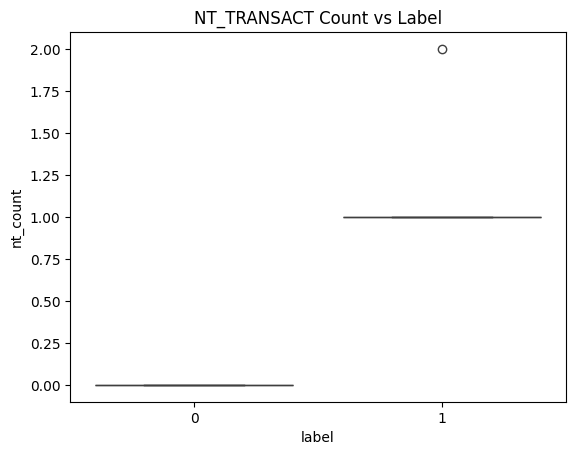

In [13]:
sns.boxplot(x="label", y="nt_count", data=session_df)
plt.title("NT_TRANSACT Count vs Label")
plt.show()

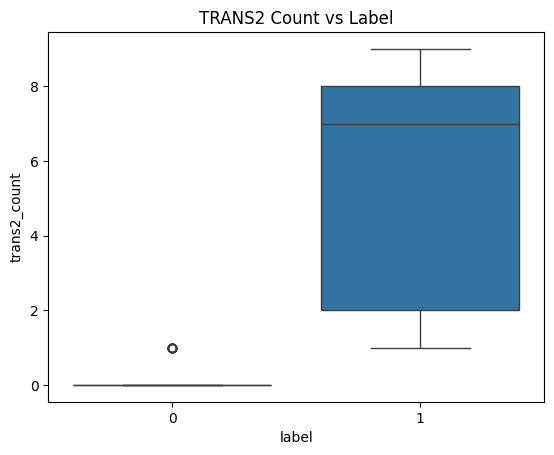

In [14]:
sns.boxplot(x="label", y="trans2_count", data=session_df)
plt.title("TRANS2 Count vs Label")
plt.show()


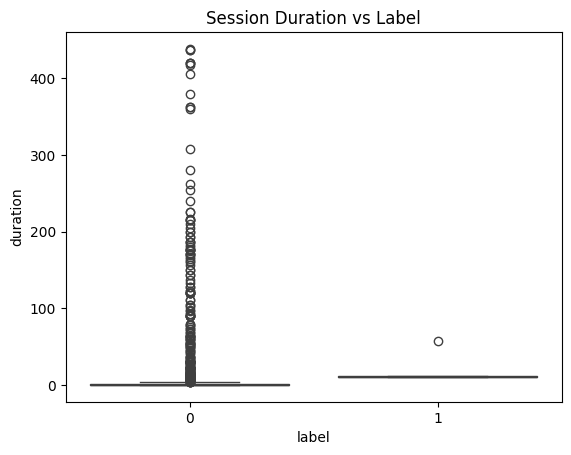

In [15]:
sns.boxplot(x="label", y="duration", data=session_df)
plt.title("Session Duration vs Label")
plt.show()


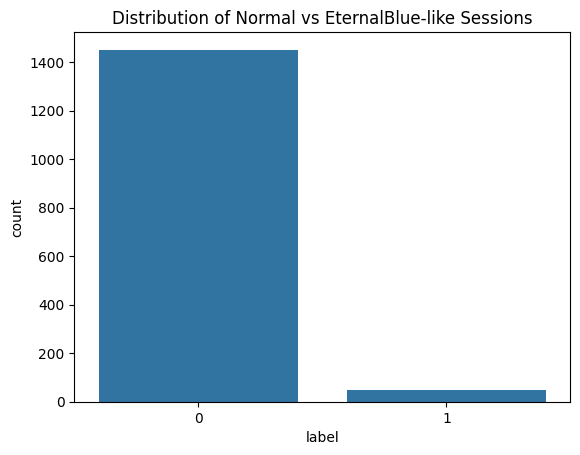

In [16]:
sns.countplot(x="label", data=session_df)
plt.title("Distribution of Normal vs EternalBlue-like Sessions")
plt.show()


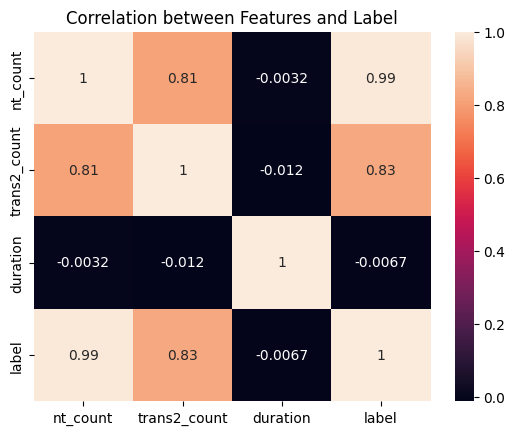

In [17]:
sns.heatmap(session_df[["nt_count", "trans2_count", "duration", "label"]].corr(), annot=True)
plt.title("Correlation between Features and Label")
plt.show()


Label counts:
 label
0    1451
1      47
Name: count, dtype: int64
Label percentage:
 label
0    96.862483
1     3.137517
Name: count, dtype: float64


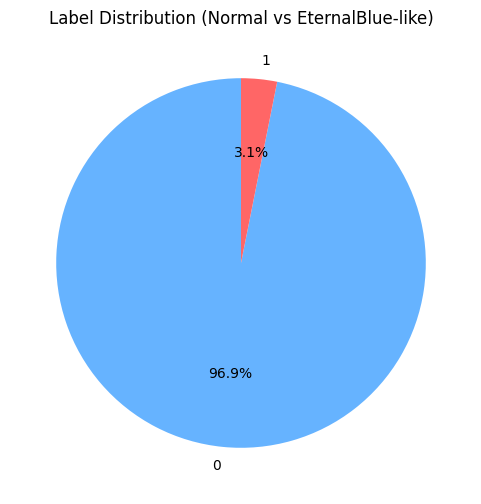

In [18]:
label_counts = session_df['label'].value_counts()
print("Label counts:\n", label_counts)
print("Label percentage:\n", label_counts / label_counts.sum() * 100)

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=90, colors=['#66b3ff','#ff6666'])
plt.title("Label Distribution (Normal vs EternalBlue-like)")
plt.show()
